In [1]:
from plotnine import *
from scipy.spatial import distance
import pandas as pd
from dtw import *
import dtaidistance as dd
from tslearn import metrics
from tssearch import plot_alignment
from tssearch.search.query_search import time_series_search
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



C:\Users\anna\miniconda3\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/


In [2]:
joined_aggregation_smooth_all = pd.read_csv("Organised/aggregation/12_joined_smooth_aggregation.csv")
joined_aggregation_all = pd.read_csv("Organised/aggregation/joined_aggregation.csv")

normalized_joined_aggregation_smooth_all = pd.read_csv("Organised/aggregation/6_normalized_smooth_aggregation.csv")
normalized_aggregation = pd.read_csv("Organised/aggregation/normalized_aggregation.csv")

joined_filtration_smooth_all = pd.read_csv("Organised/filtration/6_joined_smooth_filtration.csv")
joined_filtration_all = pd.read_csv("Organised/filtration/joined_filtration.csv")
normalized_joined_filtration_smooth_all = pd.read_csv("Organised/filtration/6_normalized_smooth_filtration.csv")
normalized_joined_filtration = pd.read_csv("Organised/filtration/normalized_filtration.csv")

joined_aggregation_filtration_smooth_all = pd.read_csv("Organised/filtration-aggregation/6_joined_smooth_filtration-aggregation.csv")
joined_aggregation_filtration_all = pd.read_csv("Organised/filtration-aggregation/joined_filtration-aggregation.csv")
normalized_joined_aggregation_filtration_smooth_all = pd.read_csv("Organised/filtration-aggregation/6_normalized_smooth_filtration-aggregation.csv")
normalized_joined_aggregation_filtration = pd.read_csv("Organised/filtration-aggregation/normalized_filtration-aggregation.csv")

In [17]:
def calculate_euclidean_distance(a_cpu, b_cpu, a_ram, b_ram):
    cpu_dst = distance.euclidean(a_cpu, b_cpu)
    ram_dst = distance.euclidean(a_ram, b_ram)
    return cpu_dst, ram_dst

def calculate_dtw_dtw_library(a_cpu, b_cpu, a_ram, b_ram):
    step_pattern = symmetric2

    alignment_cpu = dtw(a_cpu, b_cpu, step_pattern=step_pattern, keep_internals=True)
    alignment_ram = dtw(a_ram, b_ram, step_pattern=step_pattern, keep_internals=True)
    alignment_cpu.plot(type="twoway", offset=80)
    plt.show()
    return alignment_cpu.normalizedDistance, alignment_cpu.distance, alignment_ram.normalizedDistance, alignment_ram.distance

def calculate_dtw_dtaidistance_library(a_cpu, b_cpu, a_ram, b_ram):
    d_cpu = dd.dtw.distance(numpy.array(a_cpu), numpy.array(b_cpu), None, None, None, None, None, None, None, True)
    path = dd.dtw.warping_path(numpy.array(a_cpu), numpy.array(b_cpu))
    dtwvis.plot_warping(numpy.array(a_cpu), numpy.array(b_cpu), path)

    d_ram = dd.dtw.distance(numpy.array(a_ram), numpy.array(b_ram))
    return d_cpu, d_ram

def calculate_lcss(a_cpu, b_cpu, a_ram, b_ram):
    lcss_path_cpu, sim_lcss_cpu = metrics.lcss_path(a_cpu, b_cpu, eps=2.0)
    lcss_path_ram, sim_lcss_ram = metrics.lcss_path(a_ram, b_ram, eps=1.5)
    return sim_lcss_cpu, sim_lcss_ram

def calculate_lcss2(a_cpu, b_cpu, a_ram, b_ram):
    dict_distances = {
        "elastic": {"Longest Common Subsequence": {
            "multivariate": "yes",
            "description": "",
            "function": "lcss",
            "parameters": {"eps": 1.5, "report": "distance"},
            "use": "yes"}
        }
    }
    sim_lcss_cpu = time_series_search(dict_distances, numpy.array(a_cpu), numpy.array(b_cpu), output=("number", 1))["Longest Common Subsequence"]["distance"]
    sim_lcss_ram = time_series_search(dict_distances, numpy.array(a_ram), numpy.array(b_ram), output=("number", 1))["Longest Common Subsequence"]["distance"]

    result = time_series_search(dict_distances, numpy.array(a_ram), numpy.array(b_ram), output=("number", 1))
    plt.figure()
    plt.title("Longest Common Subsequence")
    plot_alignment(a_ram, b_ram, result["Longest Common Subsequence"]["path"][0])
    return sim_lcss_cpu, sim_lcss_ram

## Creating comparison dataFrame

In [18]:
def calculate_distance_and_save_as_df(df, data, snapshot1, snapshot2, function1, function2, normalized=0, smoothed=0, data2=pd.DataFrame(), max_length=496):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1]
    b = data2[data2["snapshot"] == snapshot2]
    max_length = max(len(a.index), len(b.index))

    a_cpu = list(a['CPU'])
    b_cpu = list(b['CPU'])
    a_ram = list(a['RAM'])
    b_ram = list(b['RAM'])

    a_cpu = a_cpu + [0]*(max_length - len(a_cpu))
    b_cpu = b_cpu + [0]*(max_length - len(b_cpu))
    a_ram = a_ram + [0]*(max_length - len(a_ram))
    b_ram = b_ram + [0]*(max_length - len(b_ram))

    euc_cpu_dist, euc_ram_dist = calculate_euclidean_distance(a_cpu, b_cpu, a_ram, b_ram)
    dtw_cpu_dist_normalized, dtw_cpu_dist, dtw_ram_dist_normalized, dtw_ram_dist = \
        calculate_dtw_dtw_library(a_cpu, b_cpu, a_ram, b_ram)
    dtaidistance_cpu, dtaidistance_ram = calculate_dtw_dtaidistance_library(a_cpu, b_cpu, a_ram, b_ram)
    lcss_distance_cpu, lcss_distance_ram = calculate_lcss2(a_cpu, b_cpu, a_ram, b_ram)
    new_cpu_row = {
        'dataType' : 'CPU',
        'function1' : function1,
        'snapshot1' : snapshot1,
        'udf1' : a['udf'].max(),
        'function2' : function2,
        'snapshot2': snapshot2,
        'udf2' : b['udf'].max(),
        'euclidean': euc_cpu_dist,
        'dtw-python-distance': dtw_cpu_dist,
        'dtw-python-normalizedDistance': dtw_cpu_dist_normalized,
        'dtaidistance': dtaidistance_cpu,
        'lcss_similarity': lcss_distance_cpu,
        'is_normalized': normalized,
        'is_smoothed': smoothed
    }
    new_ram_row = {
        'dataType' : 'RAM',
        'function1' : function1,
        'snapshot1' : snapshot1,
        'udf1' : a['udf'].max(),
        'function2' : function2,
        'snapshot2': snapshot2,
        'udf2' : b['udf'].max(),
        'euclidean': euc_ram_dist,
        'dtw-python-distance': dtw_ram_dist,
        'dtw-python-normalizedDistance': dtw_ram_dist_normalized,
        'dtaidistance': dtaidistance_ram,
        'lcss_similarity': lcss_distance_ram,
        'is_normalized': normalized,
        'is_smoothed': smoothed
    }
    df = df.append(new_cpu_row, ignore_index = True)
    df = df.append(new_ram_row, ignore_index = True)
    return df

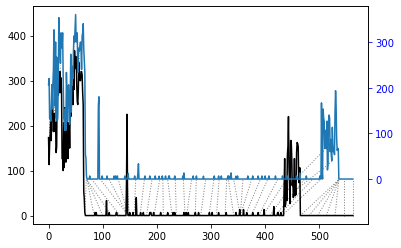

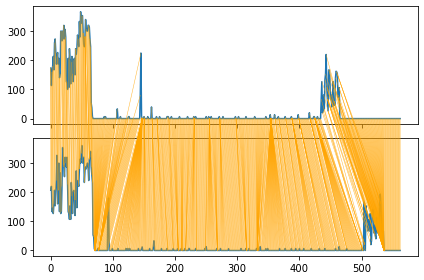

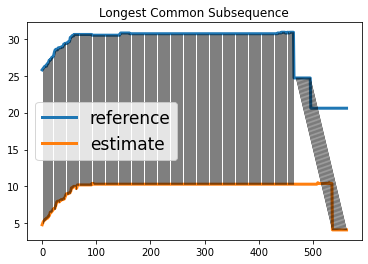

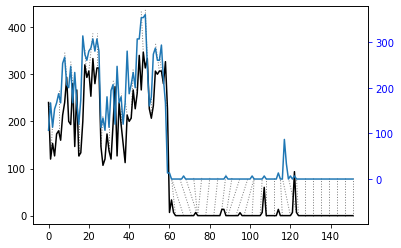

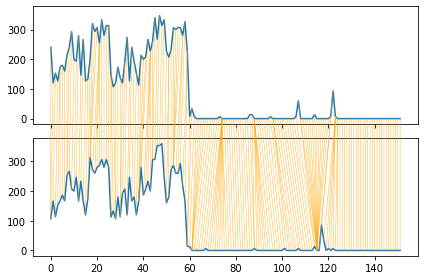

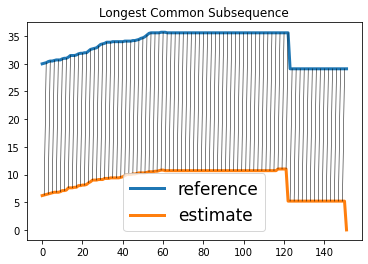

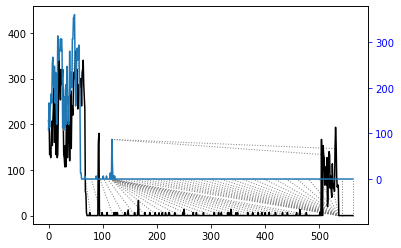

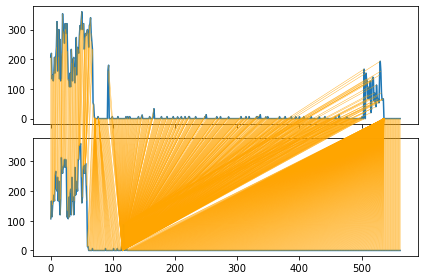

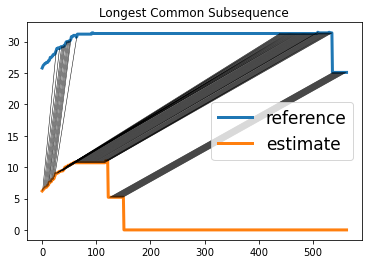

In [19]:
columns = ['dataType', 'function1', 'snapshot1','function2', 'snapshot2', 'euclidean', 'dtw-python-distance', 'dtw-python-normalizedDistance',
           'dtaidistance', 'lcss_similarity', 'is_normalized', 'is_smoothed']
dataFrame = pd.DataFrame([], columns = columns)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1,0, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 1, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 1, "aggregation", "filtration", 0, 0, joined_filtration_all, 151)


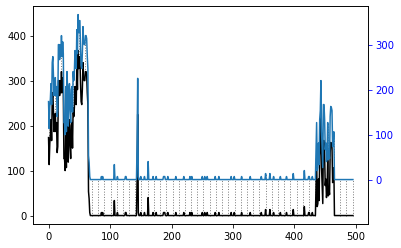

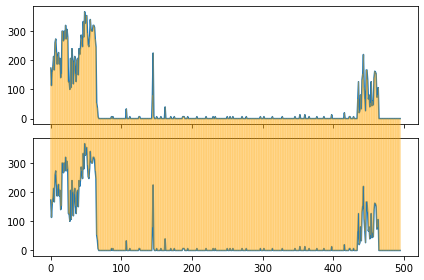

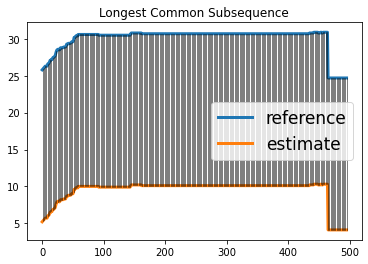

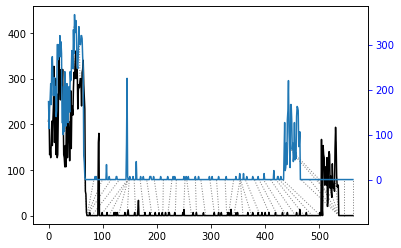

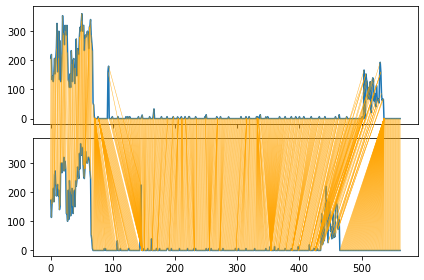

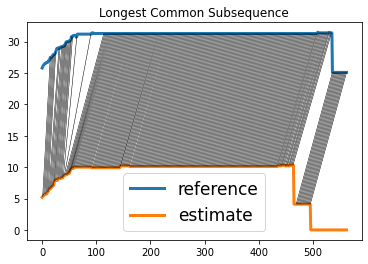

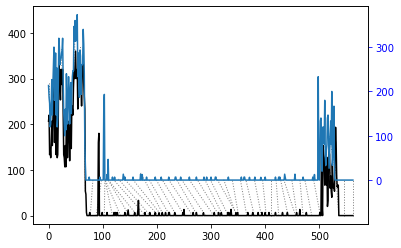

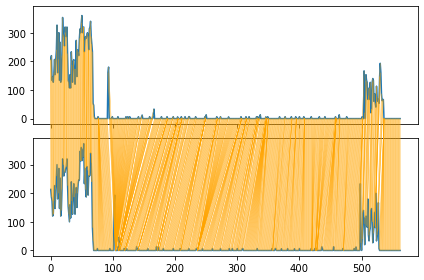

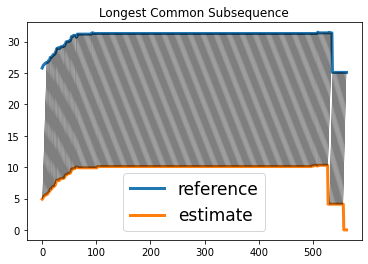

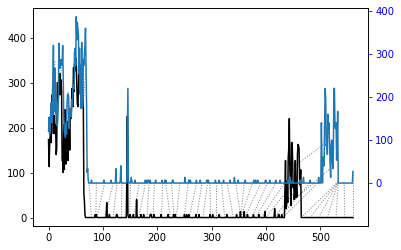

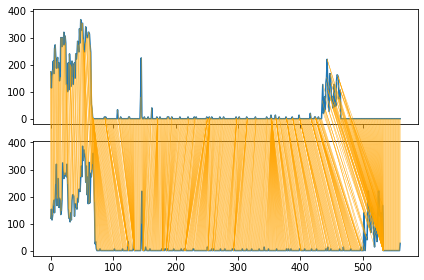

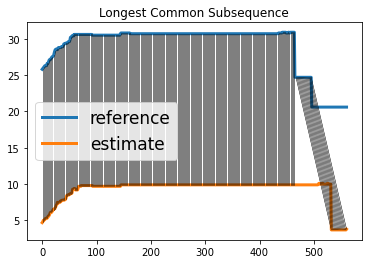

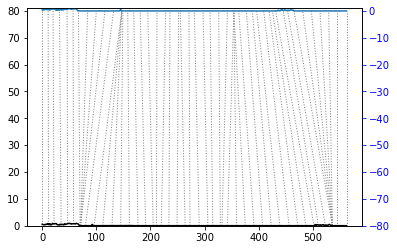

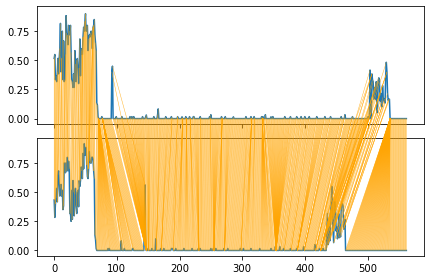

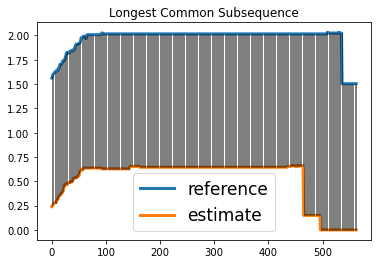

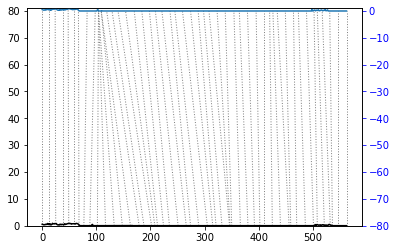

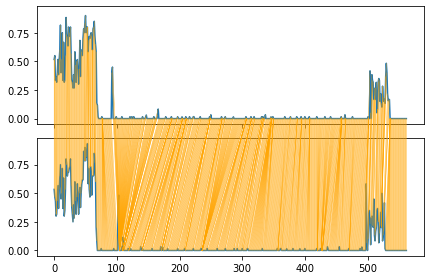

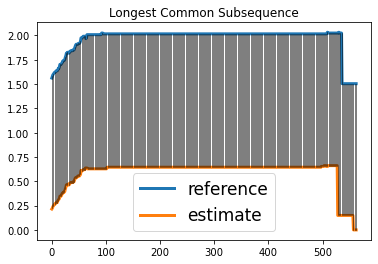

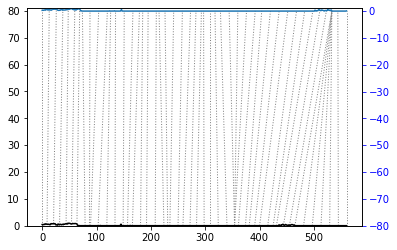

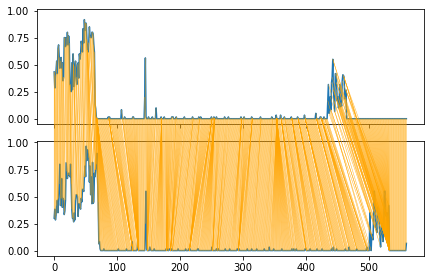

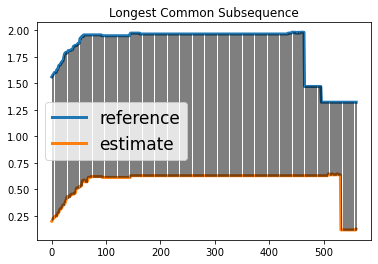

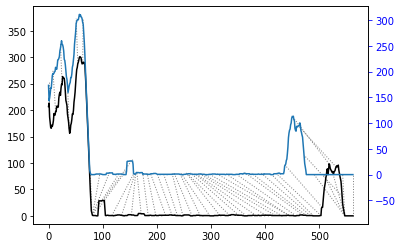

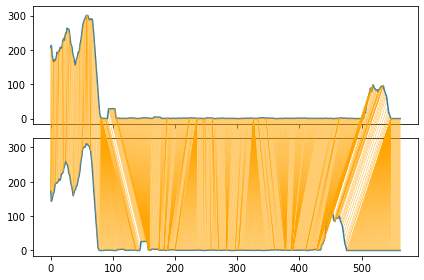

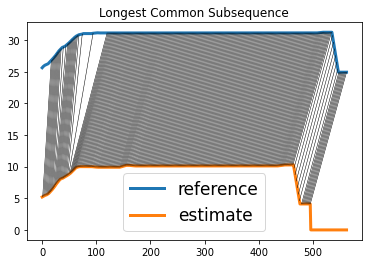

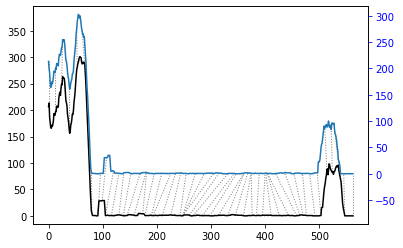

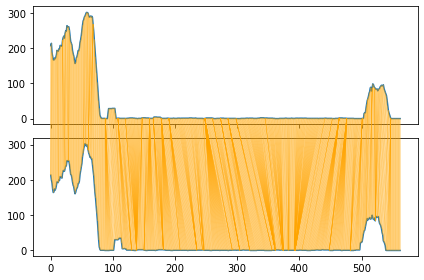

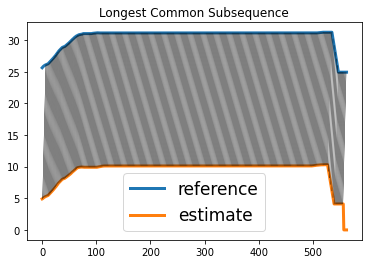

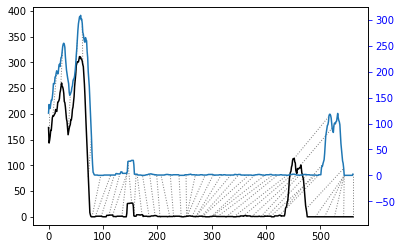

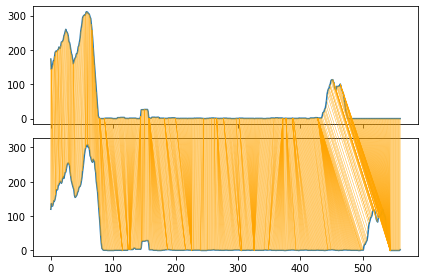

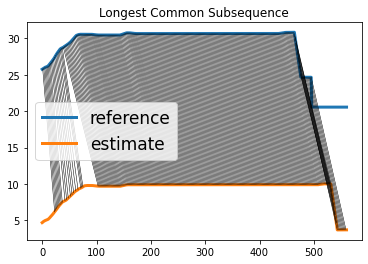

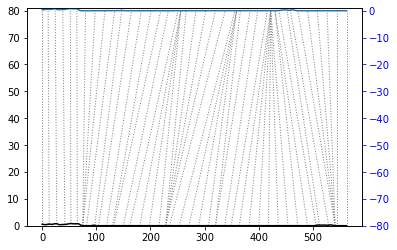

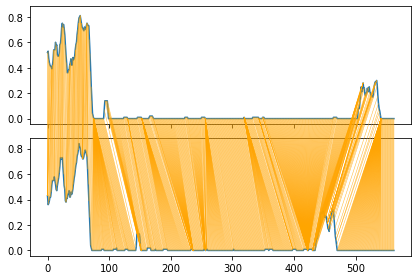

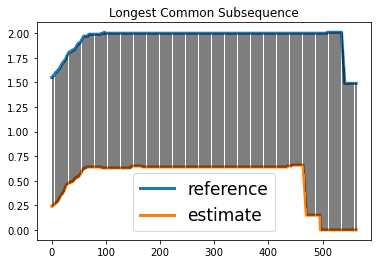

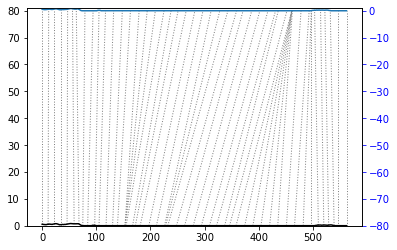

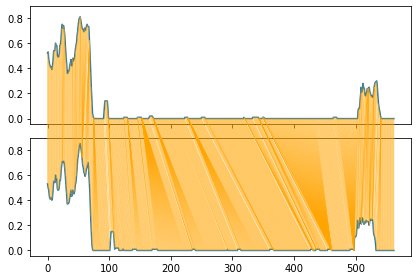

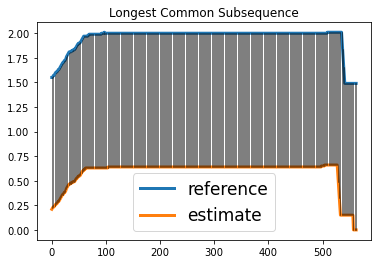

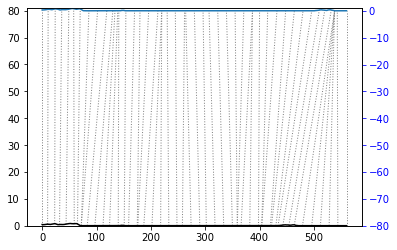

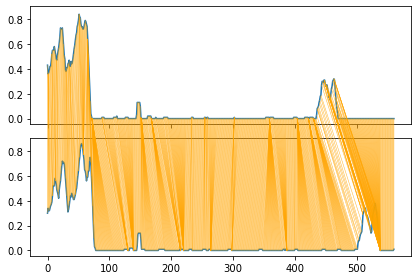

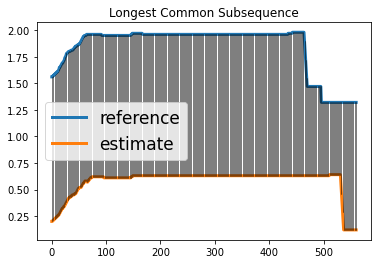

In [20]:
dataFrame = pd.DataFrame([], columns = columns)

dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1, 1, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 1, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 2, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1, 150, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 1, "aggregation", "aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 2, "aggregation", "aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 1, 150, "aggregation", "aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 1, "aggregation", "aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 2, "aggregation", "aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 1, 150, "aggregation", "aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 1, "aggregation", "aggregation", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 2, "aggregation", "aggregation", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 1, 150, "aggregation", "aggregation", 1, 1)

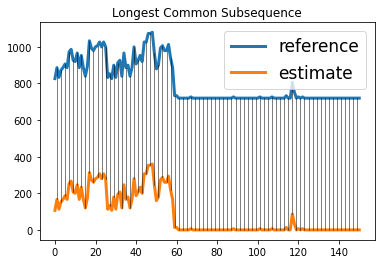

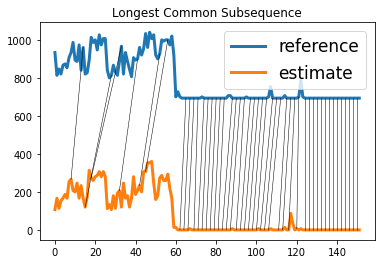

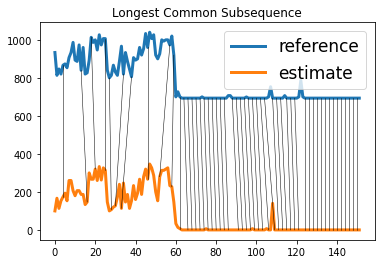

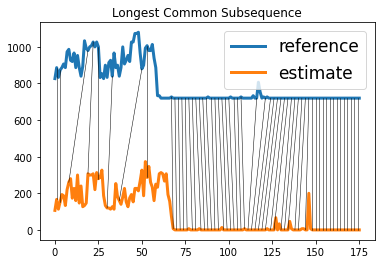

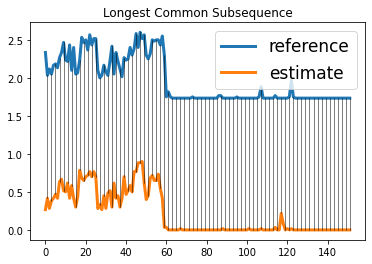

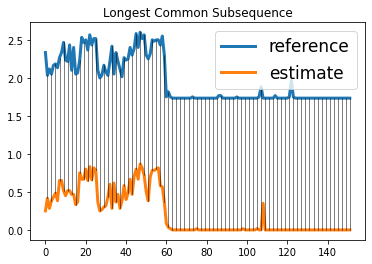

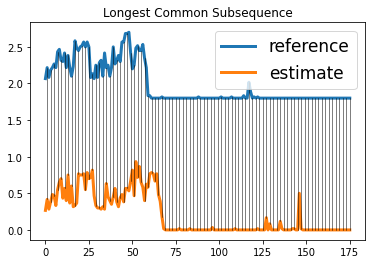

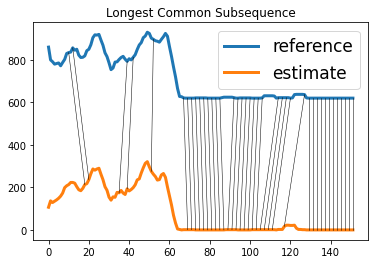

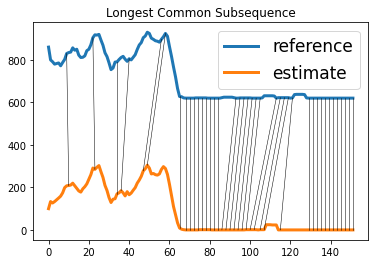

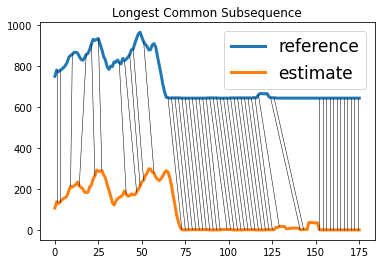

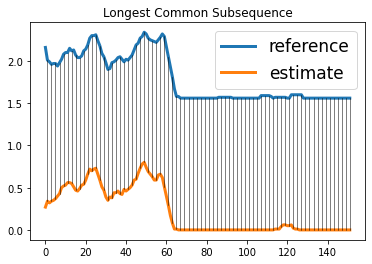

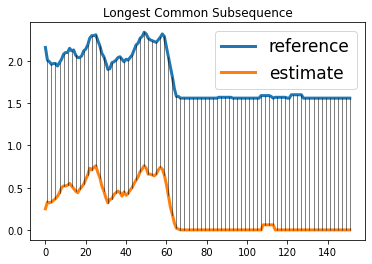

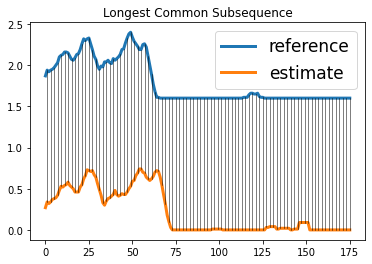

In [56]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 1, 1, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 1, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 2, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 1, 150, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 0, 1, "filtration", "filtration", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 0, 2, "filtration", "filtration", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 1, 150, "filtration", "filtration", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 0, 1, "filtration", "filtration", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 0, 2, "filtration", "filtration", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 1, 150, "filtration", "filtration", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 0, 1, "filtration", "filtration", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 0, 2, "filtration", "filtration", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 1, 150, "filtration", "filtration", 1, 1)

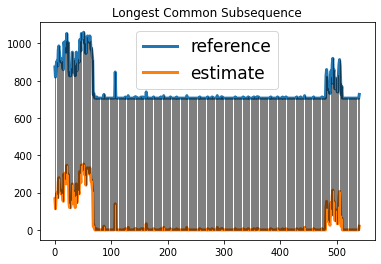

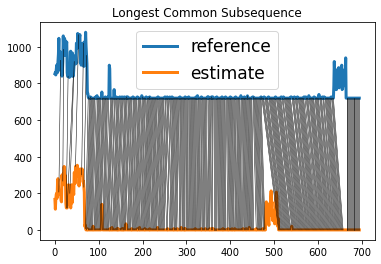

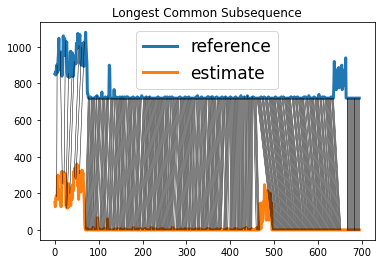

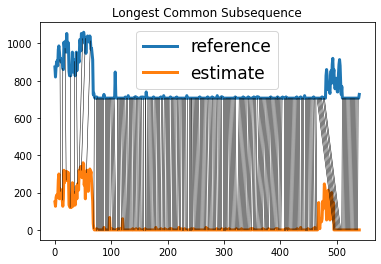

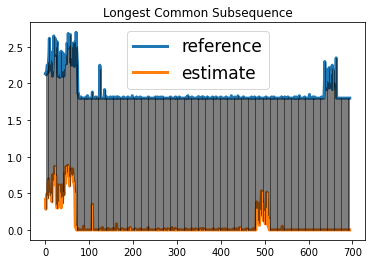

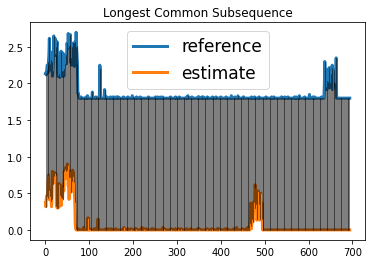

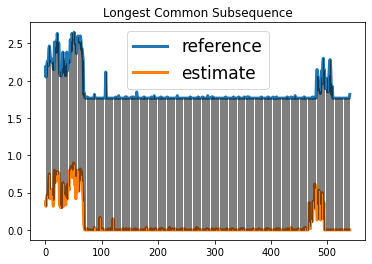

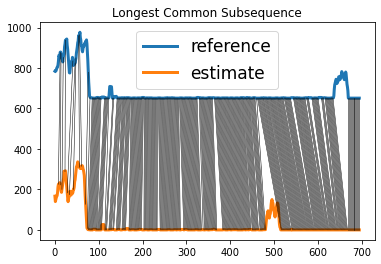

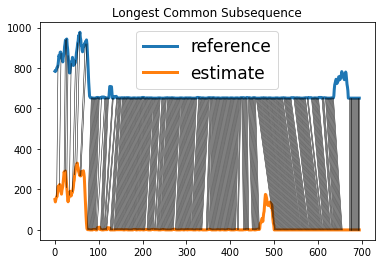

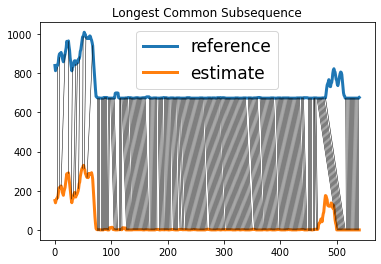

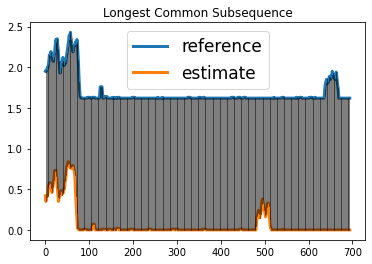

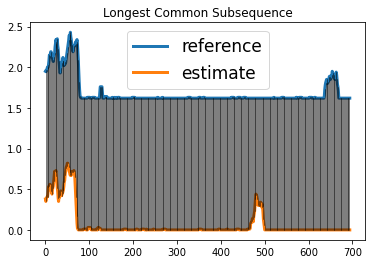

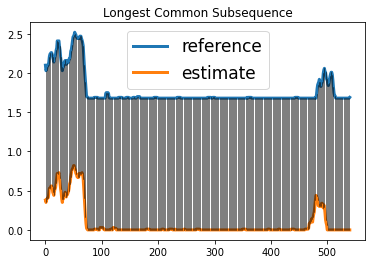

In [57]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_all, 1, 1, "filtration-aggregation", "filtration-aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_all, 0, 1, "filtration-aggregation", "filtration-aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_all, 0, 2, "filtration-aggregation", "filtration-aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_all, 1, 2, "filtration-aggregation", "filtration-aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration, 0, 1, "filtration-aggregation", "filtration-aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration, 0, 2, "filtration-aggregation", "filtration-aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration, 1, 2, "filtration-aggregation", "filtration-aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_smooth_all, 0, 1, "filtration-aggregation", "filtration-aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_smooth_all, 0, 2, "filtration-aggregation", "filtration-aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_smooth_all, 1, 2, "filtration-aggregation", "filtration-aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration_smooth_all, 0, 1, "filtration-aggregation", "filtration-aggregation", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration_smooth_all, 0, 2, "filtration-aggregation", "filtration-aggregation", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration_smooth_all, 1, 2, "filtration-aggregation", "filtration-aggregation", 1, 1)

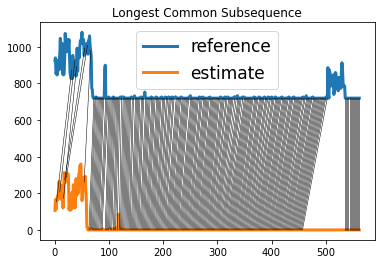

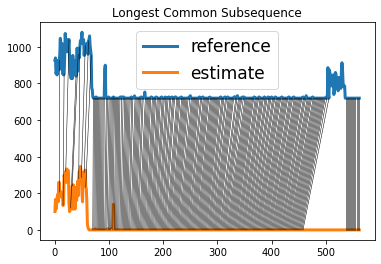

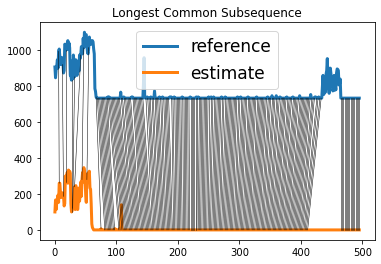

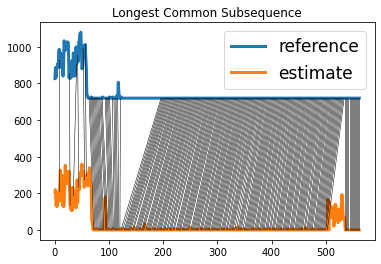

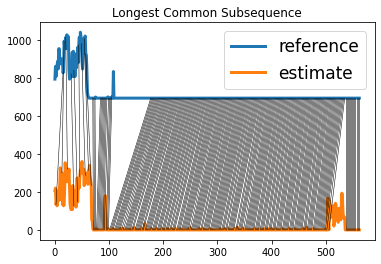

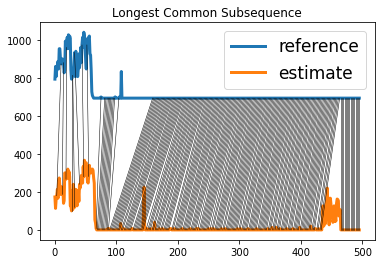

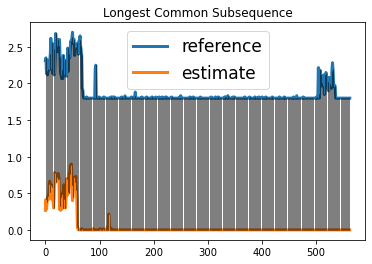

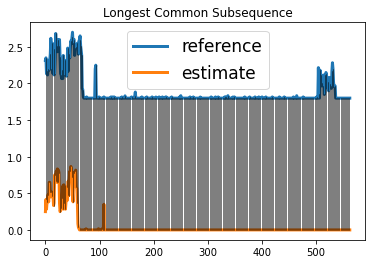

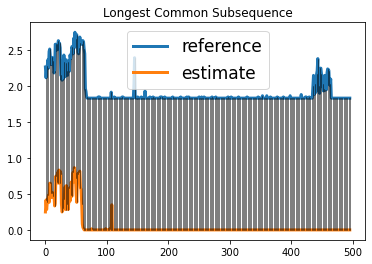

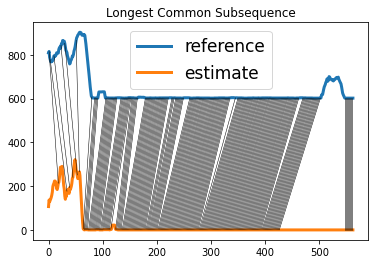

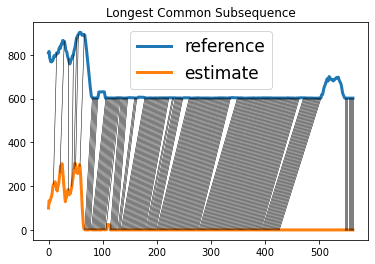

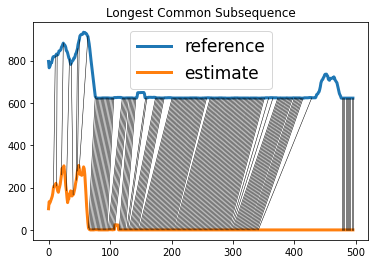

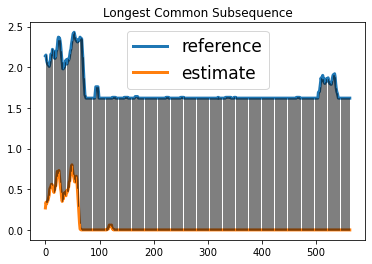

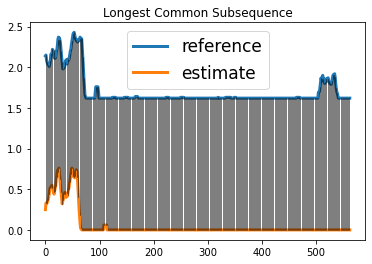

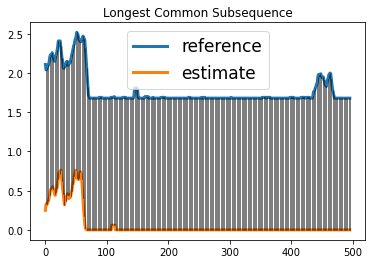

In [58]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 1, "aggregation", "filtration", 0, 0, joined_filtration_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 2, "aggregation", "filtration", 0, 0, joined_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1, 2, "aggregation", "filtration", 0, 0, joined_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 1, 0, "filtration", "aggregation", 0, 0, joined_aggregation_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 2, 0, "filtration", "aggregation", 0, 0, joined_aggregation_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 2, 1, "filtration", "aggregation", 0, 0, joined_aggregation_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 1, "aggregation", "filtration", 1, 0, normalized_joined_filtration, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 2, "aggregation", "filtration", 1, 0, normalized_joined_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 1, 2, "aggregation", "filtration", 1, 0, normalized_joined_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 1, "aggregation", "filtration", 0, 1, joined_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 2, "aggregation", "filtration", 0, 1, joined_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 1, 2, "aggregation", "filtration", 0, 1, joined_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 1, "aggregation", "filtration", 1, 1, normalized_joined_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 2, "aggregation", "filtration", 1, 1, normalized_joined_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 1, 2, "aggregation", "filtration", 1, 1, normalized_joined_filtration_smooth_all, 139)

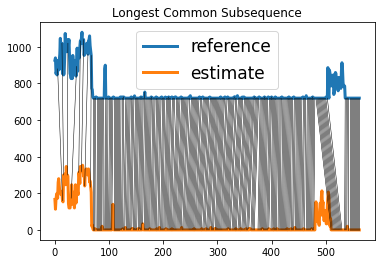

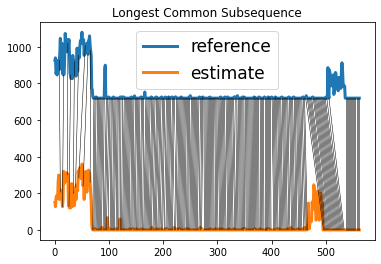

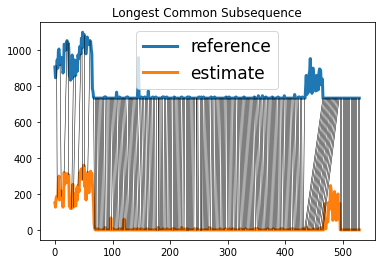

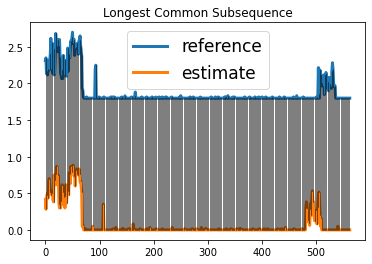

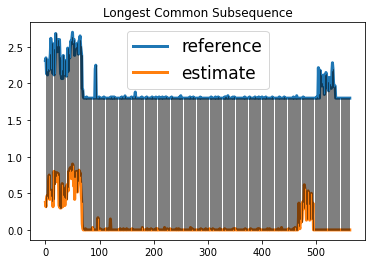

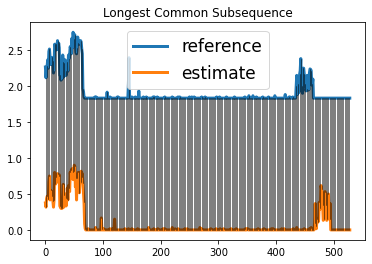

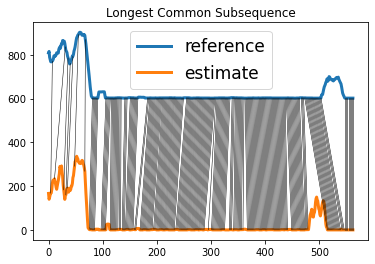

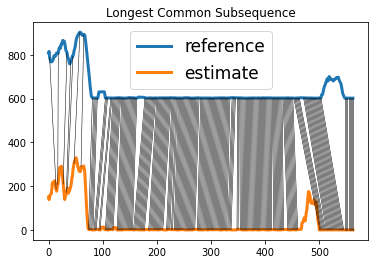

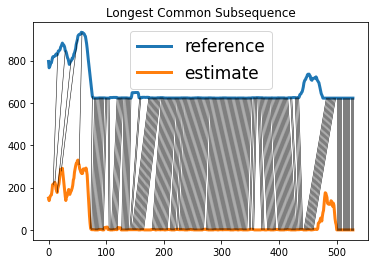

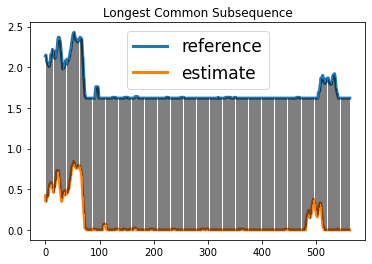

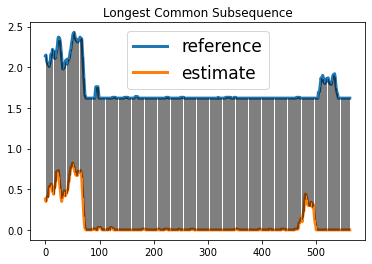

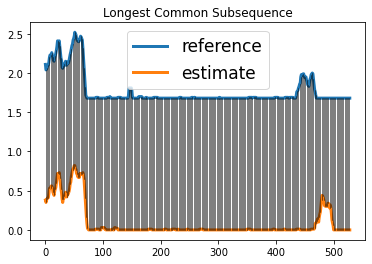

In [59]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 1, "aggregation", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 2, "aggregation", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1, 2, "aggregation", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 1, "aggregation", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 2, "aggregation", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 1, 2, "aggregation", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 1, "aggregation", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 2, "aggregation", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 1, 2, "aggregation", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 1, "aggregation", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 2, "aggregation", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 1, 2, "aggregation", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 139)


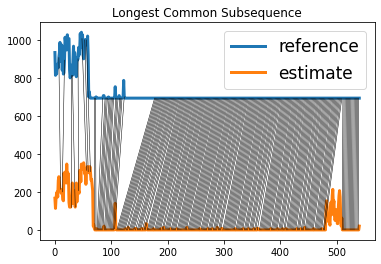

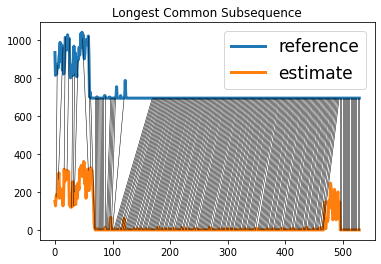

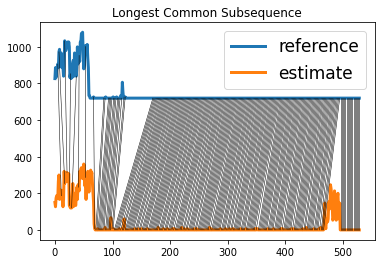

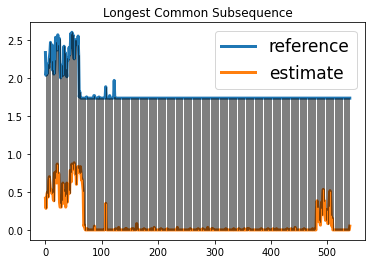

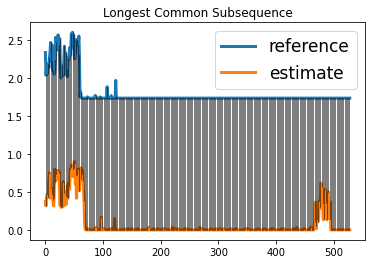

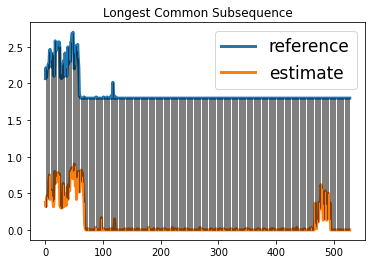

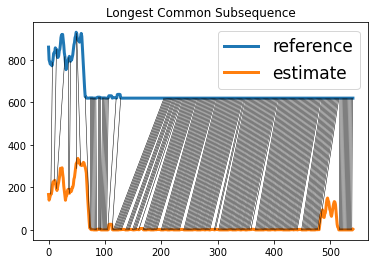

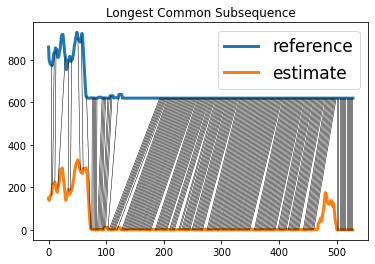

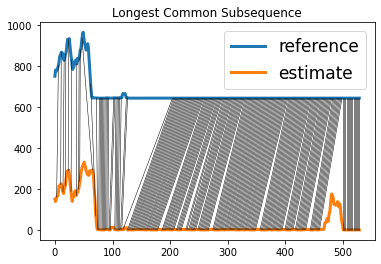

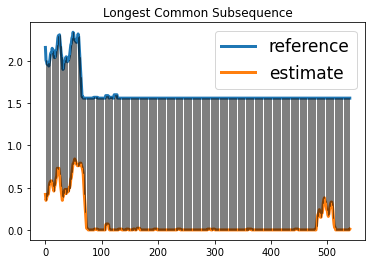

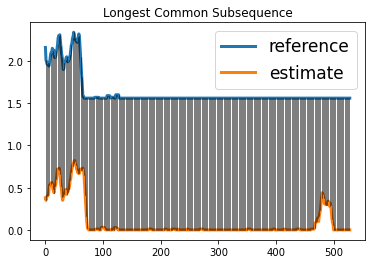

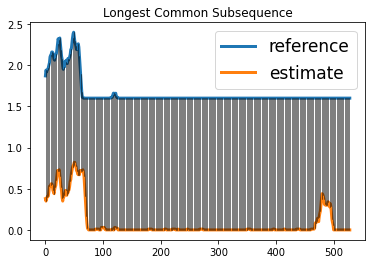

In [60]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 1, "filtration", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 2, "filtration", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 1, 2, "filtration", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 0, 1, "filtration", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 0, 2, "filtration", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 1, 2, "filtration", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 0, 1, "filtration", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 0, 2, "filtration", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 1, 2, "filtration", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 0, 1, "filtration", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 0, 2, "filtration", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 1, 2, "filtration", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 139)

In [62]:
dataFrame.to_csv("comparison_distance.csv", index=False)
dataFrame


dataType    function1 snapshot1               function2 snapshot2  \
0        CPU  aggregation         1             aggregation         1   
1        RAM  aggregation         1             aggregation         1   
2        CPU  aggregation         0             aggregation         1   
3        RAM  aggregation         0             aggregation         1   
4        CPU  aggregation         0             aggregation         2   
..       ...          ...       ...                     ...       ...   
151      RAM   filtration         0  filtration-aggregation         1   
152      CPU   filtration         0  filtration-aggregation         2   
153      RAM   filtration         0  filtration-aggregation         2   
154      CPU   filtration         1  filtration-aggregation         2   
155      RAM   filtration         1  filtration-aggregation         2   

       euclidean  dtw-python-distance  dtw-python-normalizedDistance  \
0       0.000000                 0.00                       0.000000   
1       0.000000                 0.00                       0.000000   
2    1139.176611              3901.60                       3.465009   
3      77.308085               313.60                       0.278508   
4     745.357927              3646.50                       3.238455   
..           ...                  ...                            ...   
151    15.910924               129.18                       0.119390   
152     2.311947                 9.64                       0.009112   
153    17.723183               173.19                       0.163696   
154     2.464366                 8.52                       0.008053   
155    17.833185               208.95                       0.197495   

     dtaidistance  lcss_similarity is_normalized is_smoothed  \
0        0.000000         1.000000             0           0   
1        0.000000         1.000000             0           0   
2      313.896432         0.790409             0           0   
3       33.620083         0.873890             0           0   
4      282.452669         0.804618             0           0   
..            ...              ...           ...         ...   
151      5.761415         1.000000             1           1   
152      1.368137         1.000000             1           1   
153      6.345849         1.000000             1           1   
154      1.254552         1.000000             1           1   
155      7.278207         1.000000             1           1   

                                      udf1  \
0            avgNetProfitGroupedBySoldDate   
1            avgNetProfitGroupedBySoldDate   
2            avgNetProfitGroupedBySoldDate   
3            avgNetProfitGroupedBySoldDate   
4            avgNetProfitGroupedBySoldDate   
..                                     ...   
151  filterCatalogSalesWhereProfitNegative   
152  filterCatalogSalesWhereProfitNegative   
153  filterCatalogSalesWhereProfitNegative   
154  filterCatalogSalesWhereProfitNegative   
155  filterCatalogSalesWhereProfitNegative   

                                                 udf2  
0                       avgNetProfitGroupedBySoldDate  
1                       avgNetProfitGroupedBySoldDate  
2                       avgNetProfitGroupedBySoldDate  
3                       avgNetProfitGroupedBySoldDate  
4                       avgNetProfitGroupedBySoldDate  
..                                                ...  
151  avgNetProfitGroupedBySoldDateWhereProfitNegative  
152  avgNetProfitGroupedBySoldDateWhereProfitNegative  
153  avgNetProfitGroupedBySoldDateWhereProfitNegative  
154  avgNetProfitGroupedBySoldDateWhereProfitNegative  
155  avgNetProfitGroupedBySoldDateWhereProfitNegative  

[156 rows x 14 columns]